In [13]:

import torch 
from ebm_pkg.models import get_model
from ebm_pkg.ebm.sampler import Sampler
import numpy as np 
import matplotlib.pyplot as plt 
from omegaconf import OmegaConf
from ebm_pkg.datasets import CIFAR10_MEAN, CIFAR10_STD, MNIST_MEAN, MNIST_STD

data='fashion_mnist'
path = f"../results/ebm/{data}/cnn/seed_1" #/checkpoint_{checkpoint}"
flags = OmegaConf.load(f"{path}/config.yaml")

configs = {
    "cnn" : (1, flags.activation, flags.cnn_dim, None), 
    "resnet18" : (1, flags.activation, flags.cnn_dim, flags.avg_pool_size)
}
out_features, activation, cnn_dim, last_avg_kernel_size = configs[flags.model]
model = get_model(flags.model, 
                in_channels=flags.in_channels,
                out_features=out_features,
                activation=activation,
                cnn_dim=cnn_dim,
                last_avg_kernel_size=last_avg_kernel_size)
model.load_state_dict( torch.load(f"{path}/model.pt"))

sampler = Sampler(flags.img_size, flags.maxlen)
sampler.load(f"{path}/buffer.pt")

cnn


In [14]:
def convert_to_img(tensor, means, stds):
    means = torch.tensor(means).view(len(means), 1,1)
    stds = torch.tensor(stds).view(len(means), 1,1)
    img = (tensor * stds) + means
    img = img.permute(1,2,0).numpy()
    img = img*255
    img = img.astype(int)
    img = img.clip(0,255)
    return img 

means = CIFAR10_MEAN if 'cifar' in flags.data else MNIST_MEAN
stds = CIFAR10_STD if 'cifar' in flags.data else MNIST_STD

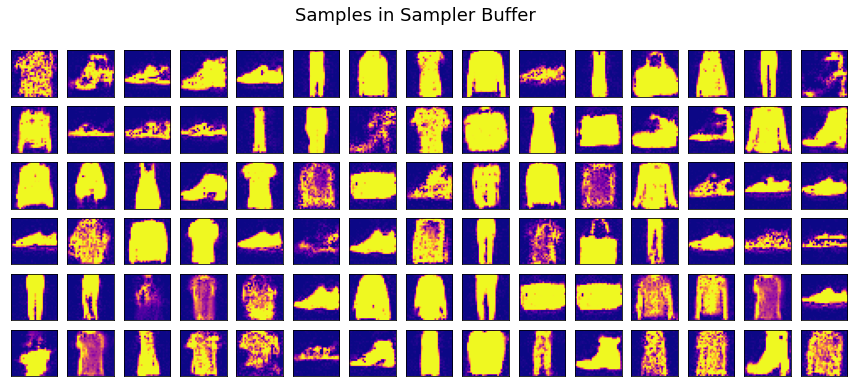

In [15]:

batch_size = 100
np.random.seed(11)
# neg_samples = sampler.sample(batch_size=batch_size, random=False) 
neg_samples = sampler.buffer[:batch_size]

N = 15
D = batch_size // N
ratio = 1.0
fig, axes = plt.subplots(D, N, figsize=(N*ratio, D*ratio))
fig.suptitle("Samples in Sampler Buffer", fontsize=18)

axes = axes.flat

for s in range(N):
    for i in range(D):
        sample=neg_samples[s*D + i]
        ax = next(axes)
        img = convert_to_img(sample, means, stds)
        ax.imshow(img, cmap='plasma')
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title(f"S:{s}")
# plt.tight_layout()

100%|██████████| 200/200 [00:11<00:00, 17.32it/s]


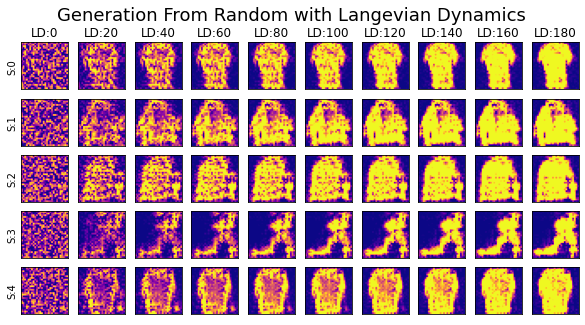

In [16]:
batch_size = 5
np.random.seed(50)
fake_init = sampler.sample(batch_size=batch_size, random=True)

# Run Langevain Dynamics
lagevian_steps = 200
lagevian_step_size = 10
neg_samples, _, buffer, _= sampler.langevian_dynamics(model, fake_init, lagevian_steps=lagevian_steps, lagevian_step_size=lagevian_step_size,  return_dynamics=True, verbose=True)

N = batch_size
D = 10
plot_steps = lagevian_steps //D
ratio = 1.0
fig, axes = plt.subplots(N, D, figsize=(D*ratio, N*ratio))
fig.suptitle("Generation From Random with Langevian Dynamics", fontsize=18)
axes = axes.flat

for s in range(N):
    for i in range(D):
        k = plot_steps * i 
        sample=buffer[s,k]
        ax = next(axes)
        img = convert_to_img(sample, means, stds)
        ax.imshow(img, cmap='plasma')
        ax.set_xticks([])
        ax.set_yticks([])
        if s ==0:
            ax.set_title(f'LD:{k}')
        if i==0:
            ax.set_ylabel(f"S:{s}")